In [106]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

import numdifftools as ndt # to comput the Hessian matrix

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Suppress future warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)

# Non-linear regression.

In order to obtain the MWC parameters given the fold-change measurements and a credible region on such parameters we will use a Bayesian approach to perform a non-linear regression.
Our theoretical model dictates that the fold change in gene expression is given by

\begin{equation}
    \text{fold-change} = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}

where $p_{act}(C)$ is given by

\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience during the regression.

If we want to fit the parameters $\epsilon_A$ and $\epsilon_I$, by Bayes theorem we have that

\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, I) \cdot P(\epsilon_A, \epsilon_I \mid I),
\end{equation}

where $D$ is the experimental data and $I$ is all the previous information.

## Gaussian likelihood and constant error

The simplest model to perform the regression is to assume the following:
1. each measurement is independent
2. the errors are Gaussian distributed
3. this error is constant along the range of IPTG.

This third assumption can be relaxed further down the road, but for now this is the easiest zero-order approximation we want to implement.

Now it is important to indicate that each element of $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$) and the independent variables (the repressor copy number $R$, the binding energy $\Delta \epsilon_r$ and the IPTG concentration $C$). With this in hand we implement the first assumption as

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}

where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain

\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\end{equation}

where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the priors we can assume that the 3 parameters $\epsilon_A, \epsilon_I$ and $\sigma$ are not only independent, but since they have a uniform prior in log scale they can have a Jeffres' prior, i.e.

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid I) \equiv \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as

\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid D, I) \propto \left( 2\pi\sigma^2 \right)^{-\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right] \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

But we are left with the nuance parameter $\sigma$ that we don't care about. To eliminate this parameter we need to marginalize over all values of $\sigma$ as

\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) = \int_{- \infty}^\infty d\sigma P(\epsilon_A, \epsilon_I, \sigma \mid D, I).
\end{equation}

And when everything settles down, i.e. after some nasty integration, we find that the posterior is given by the student-t distribution

\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto \left[ \sum_{i=1}^n \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right]^{\frac{n}{2}}. 
\end{equation}

Numerically is always better to work with the log posterior probability, therefore for the student-t distribution we have that

\begin{equation}
\ln P(\epsilon_A, \epsilon_I \mid D, I) \propto \frac{n}{2} \ln \left[ \sum_{i=1}^n \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right]
\end{equation}

Let's code up the functions to compute the theoretical fold-change

In [107]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, ea, ei, epsilon=4.5):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(ea))**2 / \
    ((1 + IPTG * np.exp(ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(ei))**2)
    return pact

def fold_change(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

Now let's code up the log posterior

In [108]:
def log_post(param, indep_var, dep_var):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, 4.5, R, epsilon_r)
    
    # return the log posterior
    return -len(dep_var) / 2 * np.log(np.sum((dep_var - fc_theory)**2))

# Testing the functions with only 1 strain and one operator 

Now it is time to test this! But first let's read the data

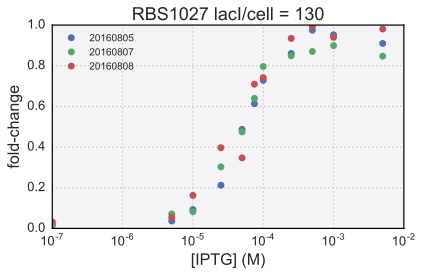

In [109]:
#Load the data. 
df_05 = pd.read_csv('../../data/20160805_O2_IPTG_titration_MACSQuant.csv',
                   comment='#')
df_07 = pd.read_csv('../../data/20160807_O2_IPTG_titration_MACSQuant.csv',
                   comment='#')
df_08 = pd.read_csv('../../data/20160808_O2_IPTG_titration_MACSQuant.csv',
                   comment='#')
# combine both DataFrames into a single one
df = pd.concat([df_05, df_07, df_08], axis=0)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

# Let's first try to do the regression using only one RBS and one operator
rbs = df[(df.rbs=='RBS1027') & (df.binding_energy==-13.9)]

plt.figure()
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG_uM / 1E6,
             rbs[rbs.date==date].fold_change_A, 'o',
            label=str(date), alpha=0.7)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.title('RBS1027 lacI/cell = 130')
plt.tight_layout()

### Plotting the posterior distribution

Before computing the MAP and doing the proper regression, let's look at the posterior itself

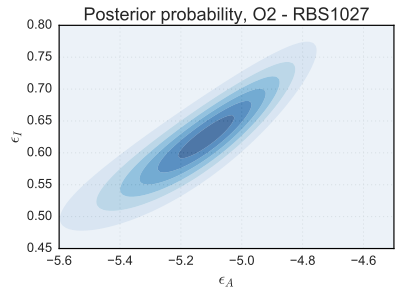

In [110]:
# Parameter values to plot
ea = np.linspace(-5.6, -4.5, 100)
ei = np.linspace(0.45, 0.8, 100)

# make a grid to plot
ea_grid, ei_grid = np.meshgrid(ea, ei)

# compute the log posterior
indep_var = rbs[['IPTG_uM', 'repressors', 'binding_energy']]
dep_var = rbs.fold_change_A

log_posterior = np.empty_like(ea_grid)
for i in range(len(ea)):
    for j in range(len(ei)):
        log_posterior[i, j] = log_post([ea_grid[i, j], ei_grid[i, j]],
                                       indep_var.values, dep_var.values)

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(ea_grid, ei_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\epsilon_A$')
plt.ylabel(r'$\epsilon_I$')
plt.title('Posterior probability, O2 - RBS1027')

### Computing the MAP

In order to compute the Maximum a posteriori parameters or MAP for short we will use the `scipy.optimize.leastsq()` function.
For this we need to define a function that computes the residuals.

In [111]:
def resid(param, indep_var, dep_var, epsilon=4.5):
    '''
    Residuals for the theoretical fold change.
    
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    fold-change_exp - fold-change_theory
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, epsilon, R, epsilon_r)
    
    # return the log posterior
    return dep_var - fc_theory

To find the most likely parameters we need to provide an initial guess. The optimization routine only finds a local maximum and is not in general guaranteed to converge. Therefore, the initial guess can be very important.

After that we will be ready to use `scipy.optimize.leastsq()` to compute the MAP. We uses the args kwarg to pass in the other arguments to the resid() function. In our case, these arguments are the data points. The `leastsq()` function returns multiple values, but the first, the optimal parameter values (the MAP), is all we are interested in.

In [112]:
# Initial guess
p0 = np.array([1, 7]) # From plotting the posterior

# Extra arguments given as tuple 
args = (indep_var.values, dep_var.values)

# Compute the MAP 
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
ea, ei = popt

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} uM
Ki = {1:.5f} uM
""".format(np.exp(-ea), np.exp(-ei)))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 166.28 uM
Ki = 0.53516 uM



Just to show that these parameters indeed give a good fit let's plot the theory and the data

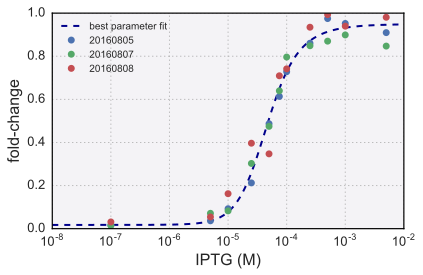

In [113]:
IPTG = np.logspace(-8, -2, 200)
fc_theory = fold_change(IPTG * 1E6, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '--', label='best parameter fit', color='darkblue')
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG_uM / 1E6,
             rbs[rbs.date==date].fold_change_A, 'o',
             label=str(date), alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

# Computing error bars on the parameters.

In order to get a **credible region** on our parameter estimate we will use an aproximation in which the posterior probability can be represented as a Gaussian distribution. This approximation can be justified as a truncated Taylor expansion as follows:
Given our log posterior distribution with parameters $\mathbf{\epsilon} = (\epsilon_A, \epsilon_I)$ we can perform a Taylor expansion around our MAP $\epsilon^*$
\begin{equation}
\ln P(\mathbf{\epsilon} \mid D, I) \approx \text{constant} + \frac{1}{2} \left(  \mathbf{\epsilon - \epsilon^*}\right)^T \cdot H \cdot \left(\mathbf{\epsilon - \epsilon^*}\right),
\end{equation}
where $H$ is the symmetric **Hessian matrix** whose entries are given by the second derivatives, i.e.
\begin{equation}
H_{ij} = \frac{\partial ^2 \ln P(\mathbf{\epsilon} \mid D, I)}{\partial \epsilon_i \partial \epsilon_j} \biggr\rvert_{\mathbf{\epsilon} = \mathbf{\epsilon^*}}.
\end{equation}

If we exponentiate this truncated expansion to remove the log we find something that remarkably resembles a multivariate Gaussian distribution
\begin{equation}
P(\mathbf{\epsilon} \mid D, I) \approx \text{constant} \cdot \exp \left[ \frac{1}{2} \left( \mathbf{\epsilon} - \mathbf{\epsilon^*} \right)^T \cdot H \cdot \left( \mathbf{\epsilon} - \mathbf{\epsilon^*} \right) \right].
\end{equation}

From this we can see that the Hessian matrix plays the role of the negative inverse **covariance matrix**. As a matter of fact since the second derivatives are evaluated at the MAP the Hessian is *positive definite* and therefore this matrix can be inverted, obtaining our desired covariance matrix. So if we compute the Hessian at the MAP, and then invert this matrix, the diagonal terms of this inverted matrix will be the error bars for our parameters under this Gaussian approximation of the posterior!

Let's now compute the covariance matrix. For this we will numerically compute the Hessian using the `numdifftools` package. We first have to initialize a `ndt.Hessian` object and then indicate where to evaluate the second derivatives.

In [114]:
# Instantiate a numdifftools Hessian object for the log posterior
hes_fun = ndt.Hessian(log_post)

# Compute the Hessian at the map
hes = hes_fun(popt, indep_var.values, dep_var.values)

hes

array([[-118.75381895,  288.58721352],
       [ 288.58721352, -884.35711488]])

Now that we computed the Hessian let's compute the negative inverse to get our precious covariance matrix!

In [115]:
# Compute the covariance matrix
cov = -np.linalg.inv(hes) 

cov

array([[ 0.04068216,  0.01327558],
       [ 0.01327558,  0.00546291]])

Again, the diagonal terms of this matrix give the approximate variance in the regression parameters. The offdiagonal terms give the covariance, which describe how parameters relate to each other. From the plot of the posterior previously we saw that there is definitely a positive correlation between the parameters, and that is reflected by non-zero entries in these offdiagonal terms.

But recall that this is giving the error bar on $\epsilon_A$ and $\epsilon_I$, not the dissociation constants themselves. Therefore we must "propagate the error" properly by doing the proper change of variables.
For this we use the approximation that if the error on $\epsilon_A$ is given by $\delta \epsilon_A$, we can use this relationship to compute $\delta K_A$, the error on the dissociation constant.

First we know the relationshipt between $\epsilon_A$ and $K_A$ is
\begin{equation}
\epsilon_A = - \ln K_A.
\end{equation}
Differenciating both sides we obtain
\begin{equation}
\delta \epsilon_A = - \frac{1}{K_A} \delta K_A.
\end{equation}
We now squre both sides and take the expected value
\begin{equation}
\langle \delta \epsilon_A \rangle^2 = \frac{\langle \delta K_A\rangle^2}{K_A^2}.
\end{equation}
Finally we re-arrange terms to find that the error bar on the dissociation constant is given by
\begin{equation}
\delta K_A = \sqrt{\langle \delta K_A \rangle^2} = \sqrt{\langle \delta \epsilon_A \rangle^2 \cdot K_A^2} = \delta \epsilon_A \cdot K_A
\end{equation}

Now let's report the parameter values with the proper error bars!

In [116]:
# Get the values for the dissociation constants and their respective error bars
Ka = np.exp(-ea)
Ki = np.exp(-ei)
deltaKa = np.sqrt(cov[0,0]) * Ka
deltaKi = np.sqrt(cov[1,1]) * Ki

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +- {1:0.3f} uM
Ki = {2:.5f} +- {3:0.6f} uM
""".format(Ka, deltaKa, Ki, deltaKi))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 166.28 +- 33.538 uM
Ki = 0.53516 +- 0.039555 uM



### Using the parameters to predict other strains
Let's extend the use of these parameters to the other strains from the same data sets.

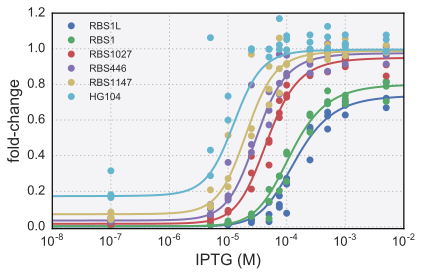

In [117]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)

plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
#     fold_change(IPTG * 1E6, ea, ei, 4.5, R=130, epsilon_r=-13.9)
    plt.plot(IPTG, fold_change(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot the experimental data
    plt.plot(df[df.rbs == rbs].sort_values(by='IPTG_uM').IPTG_uM / 1E6, 
            df[df.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0, label=rbs, color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

#### MBL data.

Now let's look at how these parameters explain the data taken at the Physiology course in 2016.

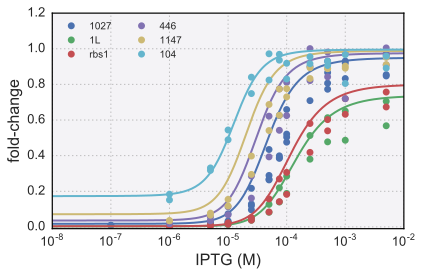

In [97]:
#Load the data. 
df_MBL = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

df_O2 = df_MBL.groupby('epsilon_r').get_group(-13.9)
plt.figure()
for i, strain in enumerate(df_O2[(df_O2.strain!='auto') & \
        (df_O2.strain!='delta')].strain.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, fold_change(IPTG * 1E6, 
        ea=ea, ei=ei, epsilon=4.5,
        R=df_O2[(df_O2.strain == strain)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot the experimental data
    plt.plot(df_O2[df_O2.strain == strain].sort_values(by='IPTG').IPTG / 1E3, 
            df_O2[df_O2.strain == strain].sort_values(by='IPTG').fold_change, 
            marker='o', linewidth=0, label=strain, color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=2)
plt.tight_layout()

# Cross checking the fit with other strains.

An interesting exercise is to perform the fit using the other strains, or pooling all the data together. 

To make this in a simple straight forward way let's define a function that takes a `pandas DataFrame` and extracts the independent and dependent variables, performs the regression and returns the MAP and error bar on the parameters $\epsilon_A$ and $\epsilon_I$.

In [98]:
def non_lin_reg_mwc(df, p0,
                    indep_var=['IPTG_uM', 'repressors', 'binding_energy'],
                    dep_var='fold_change_A', epsilon=4.5, diss_const=False):
    '''
    Performs a non-linear regression on the lacI IPTG titration data assuming
    Gaussian errors with constant variance. Returns the parameters 
    e_A == -ln(K_A)
    e_I == -ln(K_I)
    and it's corresponding error bars by approximating the posterior distribution
    as Gaussian.
    Parameters
    ----------
    df : DataFrame.
        DataFrame containing all the titration information. It should at minimum
        contain the IPTG concentration used, the repressor copy number for each
        strain and the binding energy of such strain as the independent variables
        and obviously the gene expression fold-change as the dependent variable.
    p0 : array-like (length = 2).
        Initial guess for the parameter values. The first entry is the guess for
        e_A == -ln(K_A) and the second is the initial guess for e_I == -ln(K_I).
    indep_var : array-like (length = 3).
        Array of length 3 with the name of the DataFrame columns that contain
        the following parameters:
        1) IPTG concentration
        2) repressor copy number
        3) repressor binding energy to the operator
    dep_var : str.
        Name of the DataFrame column containing the gene expression fold-change.
    epsilon : float.
        Value of the allosteric parameter, i.e. the energy difference between
        the active and the inactive state.
    diss_const : bool.
        Indicates if the dissociation constants should be returned instead of
        the e_A and e_I parameteres.
    Returns
    -------
    if diss_const  == True:
        e_A : MAP for the e_A parameter.
        de_A : error bar on the e_A parameter
        e_I : MAP for the e_I parameter.
        de_I : error bar on the e_I parameter
    else:
        K_A : MAP for the K_A parameter.
        dK_A : error bar on the K_A parameter
        K_I : MAP for the K_I parameter.
        dK_I : error bar on the K_I parameter
    '''
    df_indep = df[indep_var]
    df_dep = df[dep_var]
    
    # Extra arguments given as tuple 
    args = (df_indep.values, df_dep.values, epsilon)

    # Compute the MAP 
    popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

    # Extract the values
    ea, ei = popt
    
    # Instantiate a numdifftools Hessian object for the log posterior
    hes_fun = ndt.Hessian(log_post)

    # Compute the Hessian at the map
    hes = hes_fun(popt, df_indep.values, df_dep.values)
    
    # Compute the covariance matrix
    cov = -np.linalg.inv(hes) 
    
    if diss_const:
        # Get the values for the dissociation constants and their 
        # respective error bars
        Ka = np.exp(-ea)
        Ki = np.exp(-ei)
        deltaKa = np.sqrt(cov[0,0]) * Ka
        deltaKi = np.sqrt(cov[1,1]) * Ki 
        return Ka, deltaKa, Ki, deltaKi
    else:
        return ea, cov[0,0], ei, cov[1,1]

Now that we have the function, let's systematically perform the regression on each of the strains to check how different the parameter values are. 

In [118]:
# initialize a data frame to save the regression parameters
param_df = pd.DataFrame()
# loop through the RBS performing the regression on each strain
for i, rbs in enumerate(df.rbs.unique()):
    param =  pd.Series(non_lin_reg_mwc(df[df.rbs==rbs], p0=[-5, 1], 
                                       diss_const=True), 
                       index=['Ka', 'delta_Ka', 'Ki', 'delta_Ki'])
    param_df = pd.concat([param_df, param], axis=1)
# rename the columns by the rbs name
param_df.columns = df.rbs.unique()

# add the regression on all the pool data
param_df['pool_data'] = pd.Series(non_lin_reg_mwc(df, p0=[-5, 1], 
                                       diss_const=True), 
                       index=['Ka', 'delta_Ka', 'Ki', 'delta_Ki'])

param_df

,RBS1L,RBS1,RBS1027,RBS446,RBS1147,HG104,pool_data
Ka,249.052530,176.403545,166.281354,94.684370,111.106502,1.573901e+10,103.183857
Ki,0.737042,0.568472,0.535166,0.389312,0.440190,1.852511e-01,0.393444
delta_Ka,28.345922,16.771489,33.538819,29.143288,55.270527,4.034193e+14,11.641578
delta_Ki,0.054136,0.033546,0.039555,0.045880,0.058419,4.331013e-02,0.025652


There is certainly variability within strains. But the value of the **wild-type strain does not make any sense**. Let's plot the theoretical curves and the prediction using these parameteres.

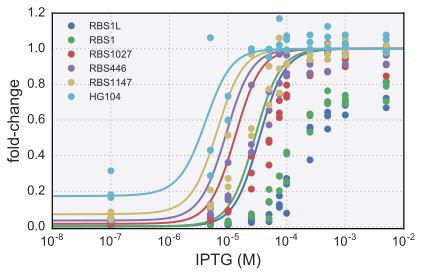

In [119]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)
par = non_lin_reg_mwc(df[df.rbs=='HG104'], p0=[-5, 1], 
                                       diss_const=False)
plt.figure()
for i, rbs in enumerate(df.rbs.unique()):
    # plot the theory using the parameters from the fit.
    plt.plot(IPTG, fold_change(IPTG * 1E6, 
        ea=par[0], ei=par[2], epsilon=4.5,
        R=df[(df.rbs == rbs)].repressors.unique(),
        epsilon_r=-13.9),
        color=colors[i])
    # plot the experimental data
    plt.plot(df[df.rbs == rbs].sort_values(by='IPTG_uM').IPTG_uM / 1E6, 
            df[df.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0, label=rbs, color=colors[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.2])
plt.legend(loc=0, ncol=1)
plt.tight_layout()

In [73]:
df_new= pd.concat([df_05, df_07], axis=0)
# Now we remove the autofluorescence and delta values
df_new= df_new[(df_new.rbs != 'auto') & (df_new.rbs != 'delta')]
# initialize a data frame to save the regression parameters
param_df_new = pd.DataFrame()
# loop through the RBS performing the regression on each strain
for i, rbs in enumerate(df_new.rbs.unique()):
    print(rbs)
    param =  pd.Series(non_lin_reg_mwc(df_new[df_new.rbs==rbs], p0=[1, 7], 
                                       diss_const=True), 
                       index=['Ka', 'delta_Ka', 'Ki', 'delta_Ki'])
    param_df_new = pd.concat([param_df_new, param], axis=1)
# rename the columns by the rbs name
param_df_new.columns = df_new.rbs.unique()

# add the regression on all the pool data
param_df_new['pool_data'] = pd.Series(non_lin_reg_mwc(df_new, p0=[1, 7], 
                                       diss_const=True), 
                       index=['Ka', 'delta_Ka', 'Ki', 'delta_Ki'])

param_df_new

RBS1L
RBS1
RBS1027
RBS446
RBS1147
HG104


,RBS1L,RBS1,RBS1027,RBS446,RBS1147,HG104,pool_data
Ka,233.689811,155.471766,143.841665,111.749047,147.347149,1.111417e+12,156.332720
Ki,0.685159,0.518445,0.522608,0.504800,0.627693,3.739938e-01,0.525589
delta_Ka,26.730854,15.822404,20.708554,18.774158,36.837478,7.781082e+16,10.258881
delta_Ki,0.050752,0.033592,0.030436,0.033309,0.043491,2.629507e-02,0.018034


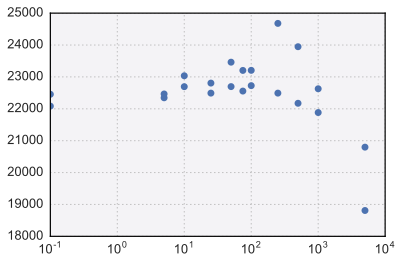

In [81]:
df_new= pd.concat([df_05, df_07], axis=0)
plt.plot(df_new[df_new.rbs=='delta'].IPTG_uM,
         df_new[df_new.rbs=='delta'].mean_YFP_A, marker='o', lw=0)
plt.xscale('log')

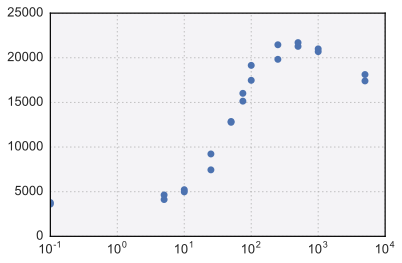

In [83]:
df_new= pd.concat([df_05, df_07], axis=0)
plt.plot(df_new[df_new.rbs=='RBS1027'].IPTG_uM,
         df_new[df_new.rbs=='RBS1027'].mean_YFP_A, marker='o', lw=0)
plt.xscale('log')